<a href="https://colab.research.google.com/github/oshbocker/snocast/blob/main/snocast_stvgp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
!pip install bayesnewton
!pip install objax

In [45]:
import bayesnewton
import objax
import pickle
import time
import sys
from scipy.cluster.vq import kmeans2
from jax.lib import xla_bridge
import json
import pandas as pd
import numpy as np
from collections import defaultdict

In [46]:
ground_measures_train = pd.read_csv('/content/drive/MyDrive/snocast/dev/ground_measures_train_features.csv')
ground_measures_train.columns = ['station_id'] + list(ground_measures_train.columns[1:])
gm_melt_train = ground_measures_train.melt(id_vars=["station_id"],
                                            var_name="date",
                                            value_name="swe").dropna()
            

ground_measures_test = pd.read_csv('/content/drive/MyDrive/snocast/dev/ground_measures_test_features.csv')
ground_measures_test.columns = ['station_id'] + list(ground_measures_test.columns[1:])
gm_melt_test = ground_measures_test.melt(id_vars=["station_id"],
                           var_name="date",
                           value_name="swe").dropna()

ground_measures_metadata = pd.read_csv('/content/drive/MyDrive/snocast/dev/ground_measures_metadata.csv')
ground_measures_all = pd.concat([ground_measures_train, ground_measures_test], axis=1)


train_labels = pd.read_csv('/content/drive/MyDrive/snocast/dev/train_labels.csv')
labels_melt_train = train_labels.melt(id_vars=["cell_id"],
                  var_name="date",
                  value_name="swe").dropna()

submission_format = pd.read_csv('/content/drive/MyDrive/snocast/dev/submission_format.csv')
preds_melt_test = submission_format.melt(id_vars=["cell_id"],
                  var_name="date",
                  value_name="swe").dropna()

train_label_unique = pd.read_csv('/content/drive/MyDrive/snocast/dev/train_label_unique.csv')
test_pred_unique = pd.read_csv('/content/drive/MyDrive/snocast/dev/test_pred_unique.csv')

# Get all of the ground measure locations that have data for every date
new_cols = [c for c in ground_measures_all.columns if c > '2014-08-01']
gm_all_non_nan = ground_measures_all.loc[ground_measures_all[new_cols].isna().sum(axis=1) == 0]

## Utils

In [47]:
def datetime_to_epoch(datetime):
    """
        Converts a datetime to a number
        args:
            datatime: is a pandas column
    """
    return datetime.astype('int64')//1e9

def epoch_to_datetime(epoch):
    return datetime.datetime.fromtimestamp(epoch)

In [48]:
def pad_with_nan_to_make_grid(X, Y):
    #converts data into grid

    N = X.shape[0]

    #construct target grid
    unique_time = np.unique(X[:, 0])
    unique_space = np.unique(X[:, 1:], axis=0)

    Nt = unique_time.shape[0]
    Ns = unique_space.shape[0]

    print('grid size:', N, Nt, Ns, Nt*Ns)

    X_tmp = np.tile(np.expand_dims(unique_space, 0), [Nt, 1, 1])

    time_tmp = np.tile(unique_time, [Ns]).reshape([Nt, Ns], order='F')

    X_tmp = X_tmp.reshape([Nt*Ns, -1])

    time_tmp = time_tmp.reshape([Nt*Ns, 1])

    #X_tmp is the full grid
    X_tmp = np.hstack([time_tmp, X_tmp])

    #Find the indexes in X_tmp that we need to add to X to make a full grid
    _X = np.vstack([X,  X_tmp])
    _Y = np.nan*np.zeros([_X.shape[0], 1])

    _, idx = np.unique(_X, return_index=True, axis=0)
    idx = idx[idx>=N]
    print('unique points: ', idx.shape)

    X_to_add = _X[idx, :]
    Y_to_add = _Y[idx, :]

    X_grid = np.vstack([X, X_to_add])
    Y_grid = np.vstack([Y, Y_to_add])

    #sort for good measure
    _X = np.roll(X_grid, -1, axis=1)
    #sort by time points first
    idx = np.lexsort(_X.T)

    return X_grid[idx], Y_grid[idx]

In [49]:
def normalise_df(x, wrt_to):
    return (x - np.mean(wrt_to, axis=0))/np.std(wrt_to, axis=0)

## Data Munging

In [50]:
# sequential swe by latitude and longitude for ground measure stations
train_gm_seq = pd.merge(gm_melt_train, ground_measures_metadata, how='inner', on='station_id')
train_gm_seq['date'] = pd.to_datetime(train_gm_seq['date'])
train_gm_seq['epoch'] = datetime_to_epoch(train_gm_seq['date'])

test_gm_seq = pd.merge(gm_melt_test, ground_measures_metadata, how='inner', on='station_id')
test_gm_seq['date'] = pd.to_datetime(test_gm_seq['date'])
test_gm_seq['epoch'] = datetime_to_epoch(test_gm_seq['date'])

In [51]:
# get latitude longitude for train and test grids
f = open('/content/drive/MyDrive/snocast/dev/grid_cells.geojson')
grid_cells = json.load(f)
print('length grid_cells features: ', len(grid_cells['features']))

grid_features = defaultdict(dict)
for grid_cell in grid_cells['features']:
  cell_id = grid_cell['properties']['cell_id']
  coordinates = grid_cell['geometry']['coordinates'][0]
  region = grid_cell['properties']['region']
  grid_features[cell_id] = {'coordinates': coordinates[1:],
                            'region': region}

grid_features_train = defaultdict(dict)
train_ids = []
train_lats = []
train_lons = []
train_regions = []
train_bboxes = []
grid_features_test = defaultdict(dict)
test_ids = []
test_lats = []
test_lons = []
test_regions = []
test_bboxes = []


for cell_id in train_labels['cell_id'].values:
  train_ids.append(cell_id)
  lon, lat = np.mean(grid_features[cell_id]['coordinates'], axis=0)
  northeast_corner = np.max(grid_features[cell_id]['coordinates'], axis=0)
  southwest_corner = np.min(grid_features[cell_id]['coordinates'], axis=0)
  # bbox = [min_lon, min_lat, max_lon, max_lat]
  bbox = np.concatenate([southwest_corner,northeast_corner])
  train_regions.append(grid_features[cell_id]['region'])
  train_lats.append(lat)
  train_lons.append(lon)
  train_bboxes.append(bbox)

  grid_features[cell_id]['dataset'] = 'train'

for cell_id in submission_format['cell_id'].values:
  test_ids.append(cell_id)
  lon, lat = np.mean(grid_features[cell_id]['coordinates'], axis=0)
  northeast_corner = np.max(grid_features[cell_id]['coordinates'], axis=0)
  southwest_corner = np.min(grid_features[cell_id]['coordinates'], axis=0)
  bbox = np.concatenate([southwest_corner,northeast_corner])
  test_regions.append(grid_features[cell_id]['region'])
  test_lats.append(lat)
  test_lons.append(lon)
  test_bboxes.append(bbox)

  if 'dataset' in grid_features[cell_id].keys():
    grid_features[cell_id]['dataset'] = 'both'
  else:
    grid_features[cell_id]['dataset'] = 'test'

for cell_id in grid_features:
  if grid_features[cell_id]['dataset'] in ('test','both'):
    grid_features_test[cell_id] = grid_features[cell_id]
  if grid_features[cell_id]['dataset'] in ('train','both'):
    grid_features_train[cell_id] = grid_features[cell_id]
print("test count: ", len(grid_features_test))
print("train count: ", len(grid_features_train))


train_lat_lon = pd.DataFrame({'cell_id': train_ids, 
                              'latitude': train_lats, 
                              'longitude': train_lons, 
                              'region': train_regions,
                              'bbox': train_bboxes})
test_lat_lon = pd.DataFrame({'cell_id': test_ids, 
                             'latitude': test_lats, 
                             'longitude': test_lons, 
                             'region': test_regions,
                             'bbox': test_bboxes})

length grid_cells features:  18130
test count:  9066
train count:  10878


In [52]:
# Create sequential dataframes for train and test
train_label_seq = pd.merge(labels_melt_train, train_lat_lon, how='inner', on='cell_id')
train_label_seq['date'] = pd.to_datetime(train_label_seq['date'])
train_label_seq['epoch'] = datetime_to_epoch(train_label_seq['date'])

test_pred_seq = pd.merge(preds_melt_test, test_lat_lon, how='inner', on='cell_id')
test_pred_seq['date'] = pd.to_datetime(test_pred_seq['date'])
test_pred_seq['epoch'] = datetime_to_epoch(test_pred_seq['date'])

In [53]:
# Create dataframes for unique locations
# train_label_unique = train_label_seq[['cell_id','latitude','longitude','bbox']].drop_duplicates('cell_id').reset_index(drop=True)
train_label_unique['dataset'] = 'train'
print("num_train_locations: ", len(train_label_unique))
#test_pred_unique = test_pred_seq[['cell_id','latitude','longitude','bbox','region']].drop_duplicates('cell_id').reset_index(drop=True)
test_pred_unique['dataset'] = 'test'
print("num_test_locations: ", len(test_pred_unique))
gm_unique = ground_measures_metadata[['station_id','latitude','longitude','elevation_m']].reset_index(drop=True)
#gm_unique.columns = ['cell_id','latitude','longitude','elevation_m']
gm_unique['dataset'] = 'gm'
print("num_gm_locations: ", len(gm_unique))

num_train_locations:  10878
num_test_locations:  9066
num_gm_locations:  700


## Use Nearest Neighbor to prune less relevant locations

In [54]:
from sklearn.neighbors import KDTree

# Builds the tree on the test data
tree = KDTree(test_pred_unique[['longitude','latitude']], leaf_size=2)

# Searches for nearest test neighbor for train_label and gm datasets
label_dist, _ = tree.query(train_label_unique[['longitude','latitude']], k=1)
gm_dist, _ = tree.query(gm_unique[['longitude','latitude']], k=1)

# Keep data with nearest test neighbor under a certain percentile
all_dist = np.concatenate([label_dist, gm_dist])
keep = np.percentile(all_dist,97)
train_label_prune = train_label_unique[(label_dist < keep).flatten()]
gm_prune = gm_unique[(gm_dist < keep).flatten()]

In [55]:
# def get_state(row):
#   return gm_unique.loc[train_ind[row.name][0]].legend

# train_label_unique['state'] = train_label_unique.apply(get_state, axis=1)

In [56]:
# Prune locations far from test data
train_label_seq = pd.merge(train_label_seq, train_label_prune[['cell_id']], how='inner')
#print(gm_prune.columns)
#gm_prune.columns = ['station_id', 'latitude', 'longitude','elevation_m','dataset']
train_gm_seq = pd.merge(train_gm_seq, gm_prune[['station_id']], how='inner')
print(train_label_prune.shape, gm_prune.shape)
print(train_label_seq.shape, train_gm_seq.shape)

# Prune measurements before September 2014
# prune_date = pd.datetime(2015, 9, 1)
# train_label_seq = train_label_seq[train_label_seq.date > prune_date]
# train_gm_seq = train_gm_seq[train_gm_seq.date > prune_date]
# print(train_label_seq.shape, train_gm_seq.shape)

(10554, 7) (676, 5)
(90842, 8) (139129, 9)


## Plot geo data

In [57]:
!pip install geopandas

#### Use Clustering to identify similar regions

In [58]:
#location_unique = pd.concat([train_label_unique, test_pred_unique, gm_unique])
location_unique = pd.concat([train_label_prune, test_pred_unique, gm_prune])
location_unique.shape

(20296, 8)

In [60]:
# scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
location_unique[['scaled_lat','scaled_lon','scaled_elev']] = scaler.fit_transform(location_unique[['latitude','longitude','elevation_m']])

In [61]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN

clustering = AgglomerativeClustering(n_clusters=50, linkage='ward').fit(location_unique[['scaled_lon','scaled_lat','scaled_elev']])
location_unique['cluster'] = clustering.labels_

In [62]:
num_cluster = 0
cluster_df_array = []
for cluster in location_unique['cluster'].unique():
  cluster_df = location_unique[location_unique['cluster'] == cluster]
  clustering = DBSCAN(eps=0.5, min_samples=2).fit(cluster_df[['scaled_lon','scaled_lat','scaled_elev']])
  cluster_df['new_cluster'] = clustering.labels_ + num_cluster
  cluster_df_array.append(cluster_df)
  num_cluster += len(np.unique(clustering.labels_))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [63]:
location_unique = pd.concat(cluster_df_array)
color_col = 'dataset'

In [33]:
# location_unique = test_pred_unique
# color_col = 'region'

In [64]:
from pylab import *
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon



color_dict = {}
unique_legend = location_unique[color_col].unique()
np.random.shuffle(unique_legend)
cmap = cm.get_cmap('tab20')
for i in range(len(unique_legend)):
  rgba = cmap(i)
  # rgb2hex accepts rgb or rgba
  color_dict[unique_legend[i]] = matplotlib.colors.rgb2hex(rgba)

In [65]:
location_unique['color'] = location_unique[color_col].apply(lambda x: color_dict[x])

In [66]:
gdf = gpd.GeoDataFrame(
    location_unique, geometry=gpd.points_from_xy(location_unique.longitude, location_unique.latitude))

In [67]:
us_map = gpd.read_file('/content/drive/MyDrive/snocast/dev/usa_map_files/usa-states-census-2014.shp')

In [68]:
west = us_map[us_map['NAME'].isin(location_unique['legend'].unique())]

In [69]:
west = west.to_crs("EPSG:3395")
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:3395")

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:405: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


[Text(0.5, 1.0, 'SWE Locations - Western United States')]

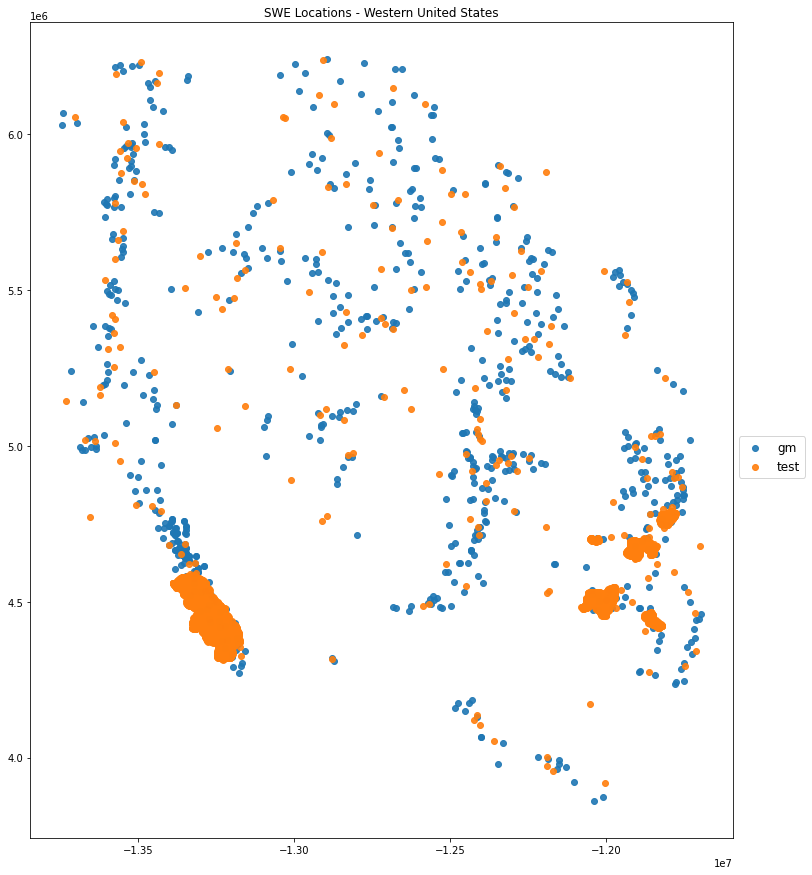

In [70]:
fig, ax = plt.subplots(figsize=(15,15))
west.boundary.plot(ax=ax)
for ctype, data in gdf.groupby(color_col):
  if ctype == 'train':
    continue
  color = color_dict[ctype]
  data.plot(ax=ax, alpha=0.9, color=color, label=ctype)

ax.legend(bbox_to_anchor=(1.0, 0.5), prop={'size': 12})
ax.set(title='SWE Locations - Western United States')

In [74]:
location_unique.dataset.unique()

array(['train', 'test', 'gm'], dtype=object)

In [75]:
location_unique[location_unique['dataset'] == 'gm'].groupby('new_cluster').count()['latitude']

new_cluster
0     39
1     32
2      9
3     32
4     34
5     48
6     12
7     25
8     73
9     23
10    19
11    21
12    33
13    20
14    41
15     6
16    14
17     4
18     5
19     1
20    12
21    17
22    43
23    43
24     7
25     6
26     3
27     7
28    20
29     2
30     4
31     6
32     3
40     6
41     6
Name: latitude, dtype: int64

In [ ]:
location_unique.groupby('new_cluster').count()['latitude']

new_cluster
0       73
1       42
2      512
3       56
4      203
5       86
6      760
7       44
8      117
9      233
10      37
11      39
12      63
13     174
14      55
15     812
16     639
17     700
18     636
19     600
20     285
21     685
22     835
23      71
24    1061
25     418
26     516
27     711
28      30
29     574
30     618
31     478
32     657
33     390
34     593
35     326
36     647
37     532
38     215
39     274
40     476
41    1174
42     468
43     688
44     576
45     297
46     327
47     179
48     191
49     123
Name: latitude, dtype: int64

In [ ]:
ground_measures_metadata.head()

,station_id,name,elevation_m,latitude,longitude,state
0,CDEC:ADM,Adin Mountain,1889.76,41.237000,-120.792000,California
1,CDEC:AGP,Agnew Pass,2880.36,37.726631,-119.141731,California
2,CDEC:ALP,Alpha (Smud),2316.48,38.804192,-120.215652,California
3,CDEC:BCB,Blackcap Basin,3139.44,37.066685,-118.773010,California
4,CDEC:BCH,Beach Meadows,2331.72,36.126095,-118.293457,California


In [ ]:
# location_unique[location_unique['new_cluster'] == 12].elevation_m.mean()

In [ ]:
# location_unique[location_unique['new_cluster'] == 13]

In [ ]:
# location_unique['new_cluster'] = location_unique['new_cluster'].apply(lambda x: 0 if x == 5 else x)
# location_unique['new_cluster'] = location_unique['new_cluster'].apply(lambda x: 12 if x == 13 else x)

In [ ]:
train_label_seq = pd.merge(train_label_seq, 
                           location_unique[location_unique['dataset'] == 'train'][['cell_id','new_cluster','elevation_m']], 
                           how='inner', 
                           on='cell_id')

In [ ]:
train_gm_seq = pd.merge(train_gm_seq, 
                           location_unique[location_unique['dataset'] == 'gm'][['station_id','new_cluster','elevation_m']], 
                           how='inner', 
                           on='station_id')

In [ ]:
test_pred_seq = pd.merge(test_pred_seq, 
                           location_unique[location_unique['dataset'] == 'test'][['cell_id','new_cluster','elevation_m']], 
                           how='inner', 
                           on='cell_id')

In [ ]:
train_label_seq['snow_season_day'] = train_label_seq.date.dt.dayofyear.apply(lambda x: x - 335 if x >= 335 else x + 30)
test_pred_seq['snow_season_day'] = test_pred_seq.date.dt.dayofyear.apply(lambda x: x - 335 if x >= 335 else x + 30)
train_gm_seq['snow_season_day'] = train_gm_seq.date.dt.dayofyear.apply(lambda x: x - 335 if x >= 335 else x + 30)

In [ ]:
snow_season_period_dict = {}
days_in_period = 7
total_days = 213
period = 0
period_count = 0
total_periods = int(total_days/days_in_period) - 1

for day in range(total_days):
  snow_season_period_dict[day] = period
  period_count += 1
  if period_count == days_in_period:
    if period != total_periods:
      period += 1
    period_count = 0

In [ ]:
train_label_seq['snow_season_period'] = train_label_seq.snow_season_day.apply(lambda x: snow_season_period_dict[x])
test_pred_seq['snow_season_period'] = test_pred_seq.snow_season_day.apply(lambda x: snow_season_period_dict[x])
train_gm_seq['snow_season_period'] = train_gm_seq.snow_season_day.apply(lambda x: snow_season_period_dict[x])

In [ ]:
join_cols = ['snow_season_period', 'new_cluster', 'swe']
cluster_seasonal_means = pd.concat([train_label_seq[join_cols], train_gm_seq[join_cols]]).groupby(['snow_season_period', 'new_cluster']).mean('swe').to_dict()['swe']
seasonal_means = pd.concat([train_label_seq[join_cols], train_gm_seq[join_cols]]).groupby(['snow_season_period', 'new_cluster']).mean('swe').to_dict()['swe']

In [ ]:
def apply_swe_mean(row):
  snow_season_period = row['snow_season_period']
  cluster = row['new_cluster']
  dict_key = (snow_season_period, cluster)
  if dict_key in cluster_seasonal_means.keys():
    return cluster_seasonal_means[dict_key]
  return 0.0

In [ ]:
train_label_seq['swe_pred'] = train_label_seq.apply(lambda x: apply_swe_mean(x), axis=1)
train_gm_seq['swe_pred'] = train_gm_seq.apply(lambda x: apply_swe_mean(x), axis=1)
test_pred_seq['swe_pred'] = test_pred_seq.apply(lambda x: apply_swe_mean(x), axis=1)

In [ ]:
np.sqrt(np.sum((train_label_seq.swe - train_label_seq.swe_pred)**2)/len(train_label_seq))

11.31629853011645

In [ ]:
np.sqrt(np.sum((train_gm_seq.swe - train_gm_seq.swe_pred)**2)/len(train_gm_seq))

10.017221293349115

In [ ]:
# 200, 7
#10.483405165011881
#9.416463419626862

In [ ]:
test_preds = test_pred_seq[['cell_id','date','swe_pred']]
test_preds['date'] = test_preds.date.apply(lambda x: x.strftime('%Y-%m-%d'))
test_preds = test_preds.pivot_table(index='cell_id', columns='date')
test_preds.columns = test_preds.columns.droplevel().rename(None)
test_preds = test_preds.reset_index(drop=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
test_preds.shape

(9066, 58)

In [ ]:
test_preds.to_csv('/content/drive/MyDrive/snocast/submissions/dev/submission_cluster.csv', index=False)

In [ ]:
test_preds.reset_index(drop=False).shape

(9066, 58)

## Prepare Data for STVGP

In [ ]:
stvgp_cols = ['epoch','latitude','longitude','swe']
stvgp_data = pd.concat([train_gm_seq, train_label_seq])

In [ ]:
stvgp_cluster = stvgp_data[stvgp_data['cluster'] == 12][stvgp_cols].reset_index(drop=True)
stvgp_cluster.sort_values(['epoch'], inplace=True)
X = np.array(stvgp_cluster[['epoch','latitude','longitude']])
Y = np.array(stvgp_cluster[['swe']])

print(X.shape, Y.shape)

(1276, 3) (1276, 1)


In [ ]:
# stvgp_cols = ['epoch','latitude','longitude','swe']
# stvgp_data = pd.concat([train_gm_seq[stvgp_cols], train_label_seq[stvgp_cols]])
# #stvgp_data = train_gm_seq[stvgp_cols]
# stvgp_data.sort_values(['epoch'], inplace=True)
# X = np.array(stvgp_data[['epoch','latitude','longitude']])
# Y = np.array(stvgp_data[['swe']])

# print(X.shape, Y.shape)

In [ ]:
# For the filtering methods to work we need a full spatio-temporal grid
X_raw, Y_raw = pad_with_nan_to_make_grid(X.copy(), Y.copy())

N = X_raw.shape[0]

print('Y: ', Y_raw.shape, ' X_raw: ', X_raw.shape)
print('statst: ', np.nanmean(Y_raw), np.nanmin(Y_raw), np.nanmax(Y_raw))

grid size: 1276 12 343 4116
unique points:  (2840,)
Y:  (4116, 1)  X_raw:  (4116, 3)
statst:  0.0007053291536050157 0.0 0.4


In [ ]:
np.isnan(Y_raw).sum()

2840

In [ ]:
Y_raw.shape

(4116, 1)

In [ ]:
# Sort the last 10 percent of data by epoch into test and remaining into train
unique_epochs = np.unique(X_raw[:, 0])
last_ten_percent = -int(len(unique_epochs)*0.2)
#print(last_ten_percent)
epoch_cutoff = unique_epochs[last_ten_percent]
train_idx = np.where(X_raw[:, 0] < epoch_cutoff)[0]
test_idx = np.where(X_raw[:, 0] >= epoch_cutoff)[0]

In [ ]:
test_idx

array([3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440,
       3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451,
       3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462,
       3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473,
       3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484,
       3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495,
       3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506,
       3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517,
       3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528,
       3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539,
       3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550,
       3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561,
       3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572,
       3573, 3574, 3575, 3576, 3577, 3578, 3579, 35

In [ ]:
#Collect training and testing data
X_train, Y_train = X_raw.copy(), Y_raw.copy()
Y_train[test_idx] = np.nan #to keep grid structure in X we just mask the testing data in the training set

X_test, Y_test = X_raw.copy(), Y_raw.copy()
Y_test[train_idx] = np.nan #to keep grid structure in X we just mask the training data in the testing set

X_all = X_raw
Y_all = Y_raw

In [ ]:
#normalise all data with respect to training data
X_train_norm = normalise_df(X_raw, wrt_to=X_train)
X_test_norm = normalise_df(X_test, wrt_to=X_train)
X_all_norm = normalise_df(X_all, wrt_to=X_train)

print('---')
print('X_train: ', X_train_norm.shape)
print('X_all: ', X_all.shape)
print(np.nanmean(Y_train), np.nanstd(Y_train))
print('Y_train: ', Y_train.shape, ' Non nans: ', np.sum(np.logical_not(np.isnan(Y_train))))
print('X_test: ', X_test_norm.shape)
print('Y_test: ', Y_test.shape, ' Non nans: ', np.sum(np.logical_not(np.isnan(Y_test))))

---
X_train:  (4116, 3)
X_all:  (4116, 3)
0.0008645533141210375 0.016668258387507375
Y_train:  (4116, 1)  Non nans:  1041
X_test:  (4116, 3)
Y_test:  (4116, 1)  Non nans:  235


## Create baseline submission that uses SVGTP

In [ ]:
mean_field = False
parallel = True
grid = True
num_z_space = 30

In [ ]:
X = X_train.copy()
Y = Y_train.copy()

X_t = X_test.copy()
Y_t = Y_test.copy()

In [ ]:
if grid:
    # the gridded approach:
    t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)
    t_t, R_t, Y_t = bayesnewton.utils.create_spatiotemporal_grid(X_t, Y_t)
else:
    # the sequential approach:
    t = X[:, :1]
    R = X[:, 1:]
    t_t = X_t[:, :1]
    R_t = X_t[:, 1:]
Nt = t.shape[0]
print("num time steps =", Nt)
Nr = R.shape[1]
print("num spatial points =", Nr)
N = Y.shape[0] * Y.shape[1] * Y.shape[2]
print("num data points =", N)

num time steps = 12
num spatial points = 343
num data points = 4116


In [ ]:
var_y = 5.
var_f = 1.
len_time = 0.001
len_space = 0.2

sparse = True
opt_z = True  # will be set to False if sparse=False

if sparse:
    z = kmeans2(R[0, ...], num_z_space, minit="points")[0]
else:
    z = R[0, ...]

kern_time = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='Full')

lik = bayesnewton.likelihoods.Gaussian(variance=var_y)

if mean_field:
    model = bayesnewton.models.MarkovVariationalMeanFieldGP(kernel=kern, likelihood=lik, X=t, R=R, Y=Y, parallel=parallel)
else:
    model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=Y, parallel=parallel)

lr_adam = 0.01
lr_newton = 1.
iters = 20
opt_hypers = objax.optimizer.Adam(model.vars())
energy = objax.GradValues(model.energy, model.vars())

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5302: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


In [ ]:
@objax.Function.with_vars(model.vars() + opt_hypers.vars())
def train_op():
    model.inference(lr=lr_newton)  # perform inference and update variational params
    dE, E = energy()  # compute energy and its gradients w.r.t. hypers
    opt_hypers(lr_adam, dE)
    return E


train_op = objax.Jit(train_op)

t0 = time.time()
for i in range(1, iters + 1):
    loss = train_op()
    print('iter %2d: energy: %1.4f' % (i, loss[0]))
t1 = time.time()
# print('optimisation time: %2.2f secs' % (t1-t0))
avg_time_taken = (t1-t0)/iters
print('average iter time: %2.2f secs' % avg_time_taken)

iter  1: energy: 1823.4287
iter  2: energy: 1821.9138
iter  3: energy: 1820.3693
iter  4: energy: 1818.8432
iter  5: energy: 1817.3469
iter  6: energy: 1815.8805
iter  7: energy: 1814.4480
iter  8: energy: 1813.0448
iter  9: energy: 1811.6512
iter 10: energy: 1810.2515
iter 11: energy: 1808.8417
iter 12: energy: 1807.4270
iter 13: energy: 1806.0141
iter 14: energy: 1804.6071
iter 15: energy: 1803.2068
iter 16: energy: 1801.8120
iter 17: energy: 1800.4221
iter 18: energy: 1799.0373
iter 19: energy: 1797.6582
iter 20: energy: 1796.2841
average iter time: 3.38 secs


In [ ]:
#objax.io.load_var_collection('/content/drive/MyDrive/snocast/stvgp_models/cluster12.npz', model.vars())

In [ ]:
posterior_mean, posterior_var = model.predict_y(X=t_t, R=R_t)
nlpd = model.negative_log_predictive_density(X=t_t, R=R_t, Y=Y_t)
rmse = np.sqrt(np.nanmean((np.squeeze(Y_t) - np.squeeze(posterior_mean))**2))
print('nlpd: %2.3f' % nlpd)
print('rmse: %2.3f' % rmse)

cpugpu = xla_bridge.get_backend().platform
# 300 iter
# nlpd: 20.155
# rmse: 28.876

nlpd: 1.770
rmse: 0.000


In [ ]:
import jax

In [ ]:
posterior_mean[~np.isnan(np.squeeze(Y_t))]

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [ ]:
np.nanmean(Y_t)

0.0

In [ ]:
posterior_mean.shape

(12, 343)

In [ ]:
np.squeeze(posterior_mean)

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)

In [ ]:
objax.io.save_var_collection('/content/drive/MyDrive/snocast/dev/stvgp_models/cluster12.npz', model.vars())

In [ ]:
posterior_mean

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)

In [ ]:
posterior_var.shape

(12, 343)

In [ ]:
posterior_mean, posterior_var = cluster12.predict_y(X=t_t, R=R_t)
nlpd = cluster12.negative_log_predictive_density(X=t_t, R=R_t, Y=Y_t)
rmse = np.sqrt(np.nanmean((np.squeeze(Y_t) - np.squeeze(posterior_mean))**2))
print('nlpd: %2.3f' % nlpd)
print('rmse: %2.3f' % rmse)

NameError: ignored

In [ ]:
submission = submission_format.copy()

for row_idx, row in submission.iterrows():
  cell_id = row['cell_id']
  cell_features = grid_features_test[cell_id]
  region = cell_features['region']
  for col in submission.columns:
    if col != 'cell_id':
      month = col.split('-')[1]
      if month in region_swe_mean_by_month[region]:
        submission.at[row_idx, col] = region_swe_mean_by_month[region][month]


In [ ]:
submission.to_csv('/content/drive/MyDrive/snocast/dev/submission_region_baseline.csv', index=False)